In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio
import matplotlib.pyplot as plt
from tqdm import tqdm

from data import SyntheticNotesDataset
from model import WaveNetAutoencoder
from train import train_model

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Generated note with MIDI pitch: 66


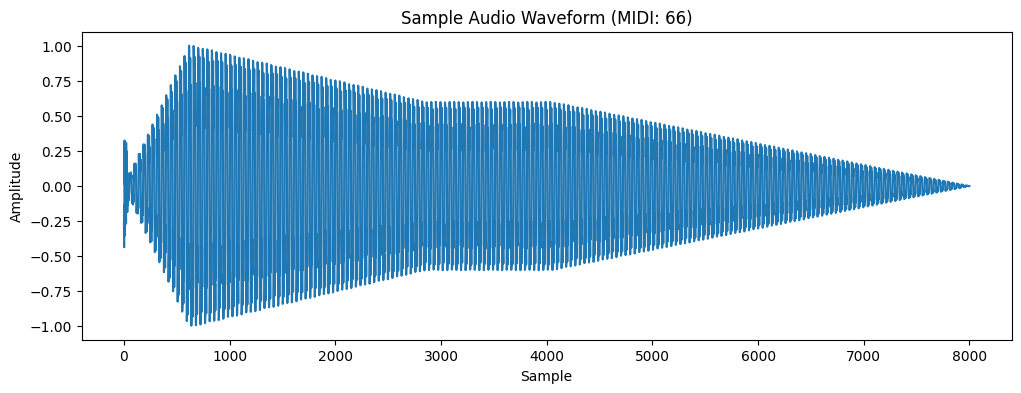

In [2]:
# Create dataset and dataloader
dataset = SyntheticNotesDataset(num_samples=5000, duration=0.5)  # 0.5-second notes
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Let's listen to a sample
sample_audio, sample_midi = dataset[0]
print(f"Generated note with MIDI pitch: {sample_midi.item() + dataset.min_midi}")
display(Audio(sample_audio.numpy(), rate=16000))

# Plot the sample
plt.figure(figsize=(12, 4))
plt.plot(sample_audio.numpy())
plt.title(f"Sample Audio Waveform (MIDI: {sample_midi.item() + dataset.min_midi})")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [3]:
# Initialize model
input_length = 8000  # 0.5 seconds at 16kHz
model = WaveNetAutoencoder(input_length=input_length, latent_dim=128, num_dilated_layers=5).to(device)
model.load_state_dict(torch.load('wavenet_autoencoder.pth'))

# Print model summary
print(model)

WaveNetAutoencoder(
  (encoder_conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (encoder_dilated_convs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  )
  (encoder_final): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(256, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): Tanh()
  )
  (decoder_initial): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, m

In [4]:
# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, dataloader, num_epochs=10)

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'device' is not defined

In [2]:
# Save
torch.save(model.state_dict(), 'wavenet_autoencoder.pth')

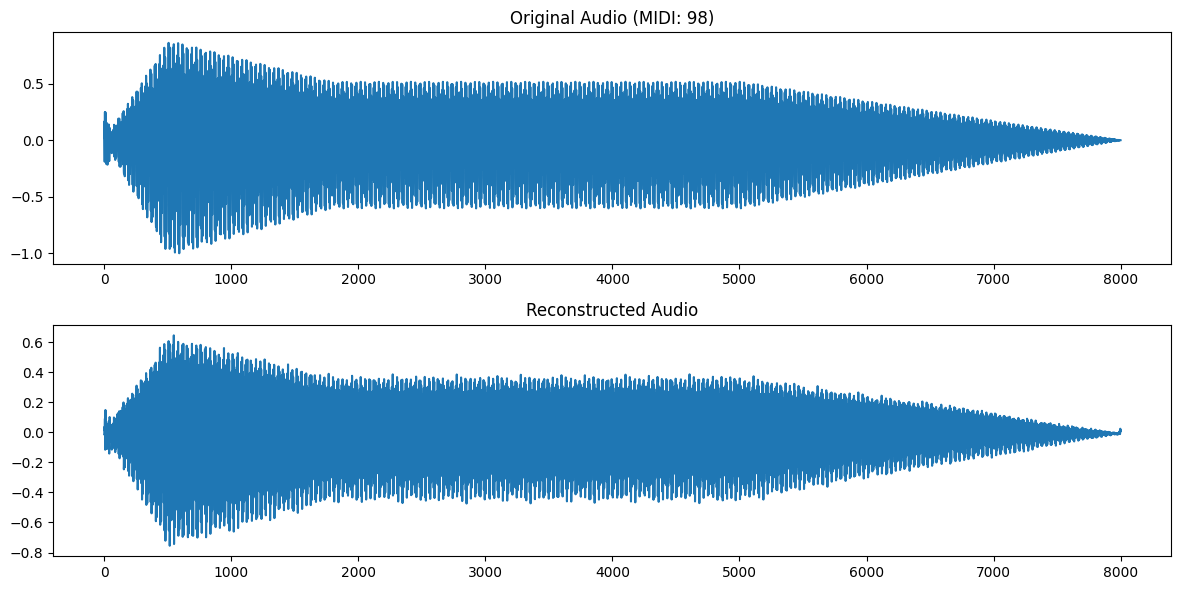

Original:


Reconstructed:


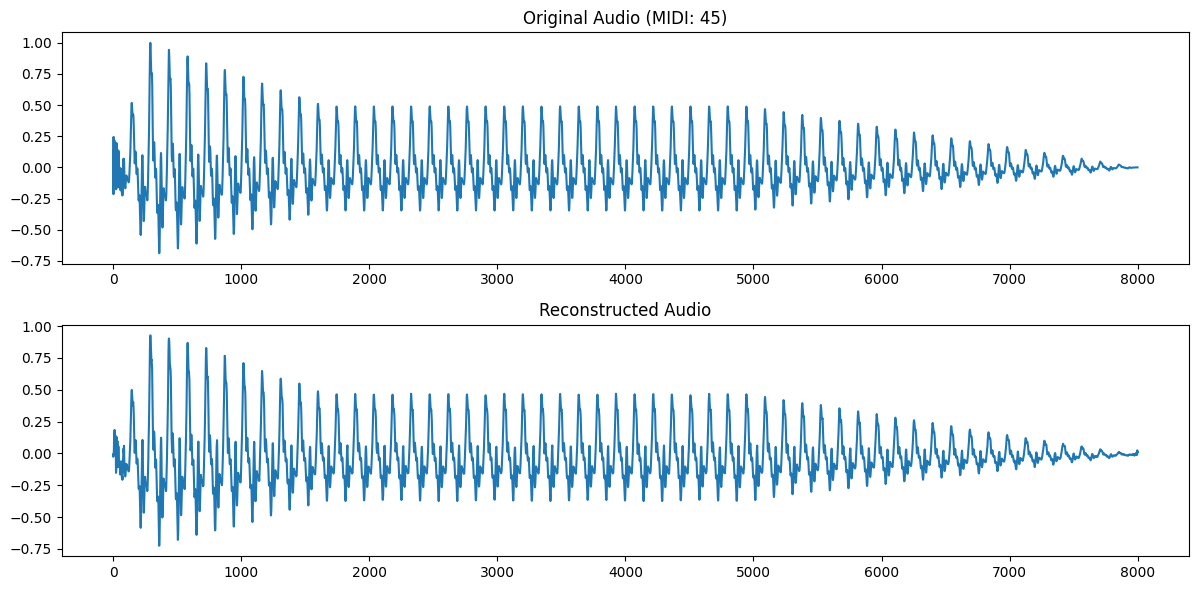

Original:


Reconstructed:


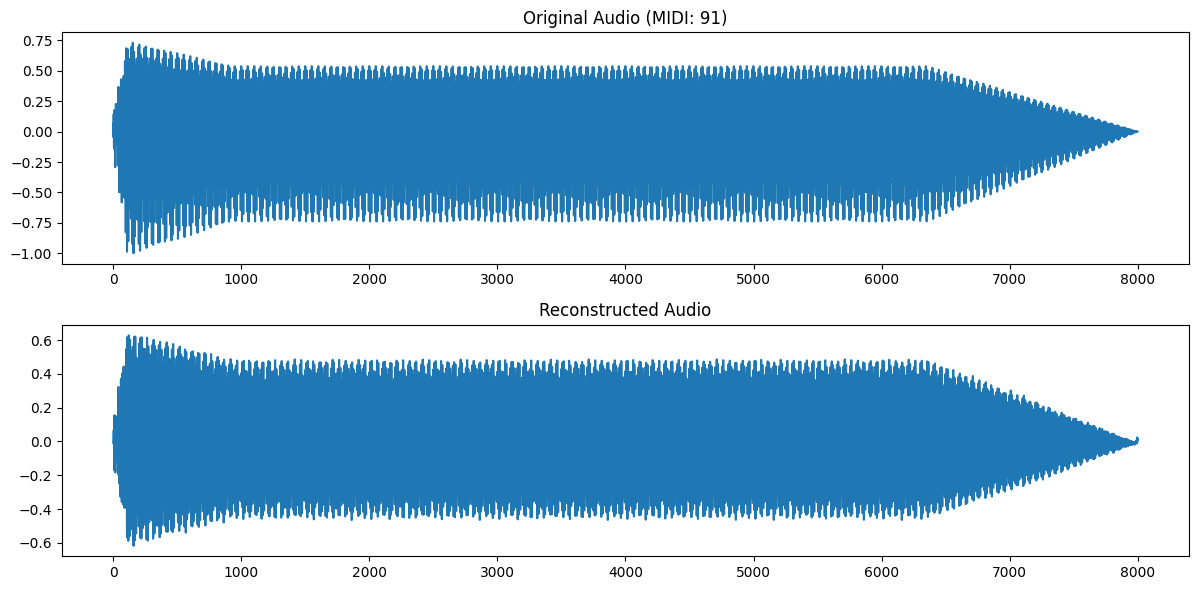

Original:


Reconstructed:


In [7]:
# Evaluation
def evaluate_model(model, dataset, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            # Get a sample
            audio, midi = dataset[i]
            original_audio = audio.numpy()
            
            # Prepare input
            audio = audio.unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dims
            
            # Reconstruct
            reconstructed = model(audio)
            reconstructed_audio = reconstructed.squeeze().cpu().numpy()
            
            # Plot
            plt.figure(figsize=(12, 6))
            plt.subplot(2, 1, 1)
            plt.plot(original_audio)
            plt.title(f'Original Audio (MIDI: {midi.item() + dataset.min_midi})')
            
            plt.subplot(2, 1, 2)
            plt.plot(reconstructed_audio)
            plt.title('Reconstructed Audio')
            
            plt.tight_layout()
            plt.show()
            
            # Play audio
            print("Original:")
            display(Audio(original_audio, rate=16000))
            print("Reconstructed:")
            display(Audio(reconstructed_audio, rate=16000))

# Evaluate
evaluate_model(model, dataset)

# Save model
torch.save(model.state_dict(), 'wavenet_autoencoder.pth')